In [2]:
# download embeds. only run this if you don't already have them
from huggingface_hub import snapshot_download
snapshot_download(repo_id="amphora/pythia-12b-weights", 
                  local_dir='pythia-12b-weights',
                  local_dir_use_symlinks=False,
                  allow_patterns="embed_only_0-29000.pkl")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

embed_only_0-29000.pkl:   0%|          | 0.00/41.5G [00:00<?, ?B/s]

'/home/pyn/pythia-embedding-analysis/notebooks/pythia-12b-weights'

In [1]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
import matplotlib.pyplot as plt
import numpy as np

cuda


Here we actually do the pairwise processing of cos sim for everything at once using pytorch GPU which is faster than iteratively sklearn computing it.

In [2]:
def cos_sim(embed_matrix):
    """
    Takes in embedding matrix at any step. ensure it is on cuda for MAXIMUM EFFICIENCY.
    Expected that the output cosine similarity matrix is of torch.Size([50688, 50688]) and norms matrix is torch.Size([50688])
    """
    weights = embed_matrix
    norms = weights.norm(dim=1)
    embedding_matrix_norm = weights / norms[:, None]
    cosine_similarity = torch.mm(embedding_matrix_norm, embedding_matrix_norm.transpose(0,1))
    return cosine_similarity, norms

In [3]:
import pickle
from pathlib import Path

Path("./pairwise-sims/").mkdir(parents=True, exist_ok=True)

files = [
    './pythia-12b-weights/embed_only_0-29000.pkl',
    #'./pythia-12b-weights/embed_only_30000-69000.pkl',
    #'./pythia-12b-weights/embed_only_70000-109000.pkl',
    #'./pythia-12b-weights/embed_only_110000-143000.pkl'
]

for filename in files:
    with open(filename, 'rb') as in_file:
        data = pickle.load(in_file)
        for step_idx, embeddings in data.items():
            sim_matrix, norms = cos_sim(torch.from_numpy(embeddings).to(device))
            sim_matrix, norms = sim_matrix.to('cpu'), norms.to('cpu')
            outfile_name = f"./pairwise-sims/{step_idx}.pkl"
            with open(outfile_name, "wb") as outfile:
                pickle.dump((sim_matrix.numpy(), norms.numpy()), outfile)

KeyboardInterrupt: 

A bit of sample visualisation. Now the real question is how to visualise it across time without absolutely butchering the CPU memory.

Right now, im just going to subsample a single selection of embedding indices, then iterate through steps, loading and unloading the matrices from memory as we go.

I'm open to much better implementations.

sampling from embedding at indices [41309 24486 45990]
./pairwise-sims/step0.pkl
./pairwise-sims/step1.pkl
./pairwise-sims/step2.pkl


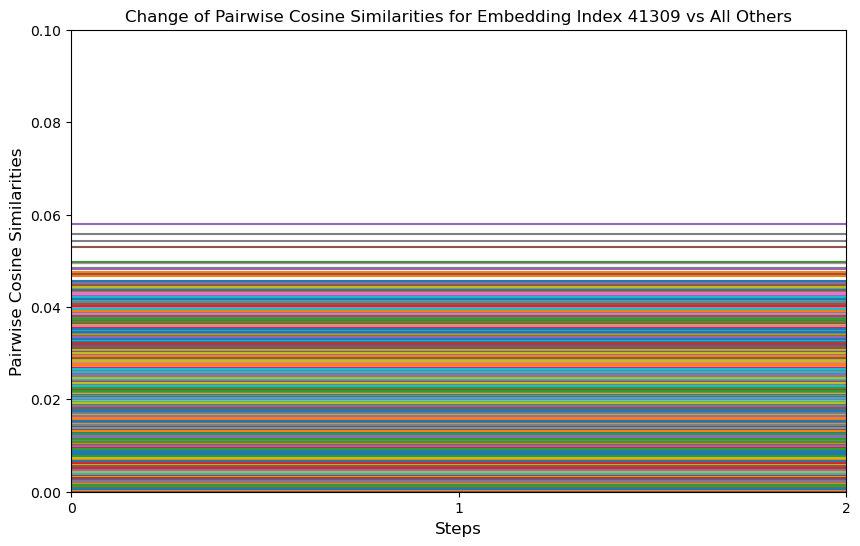

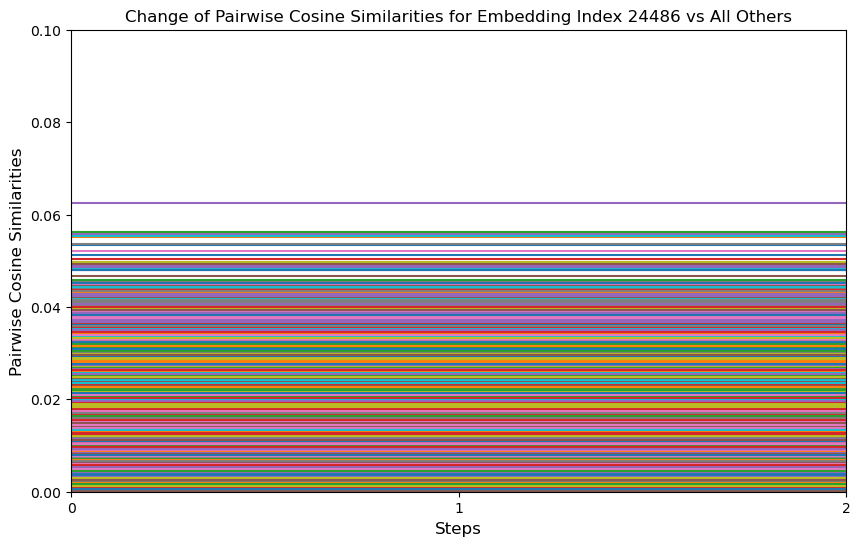

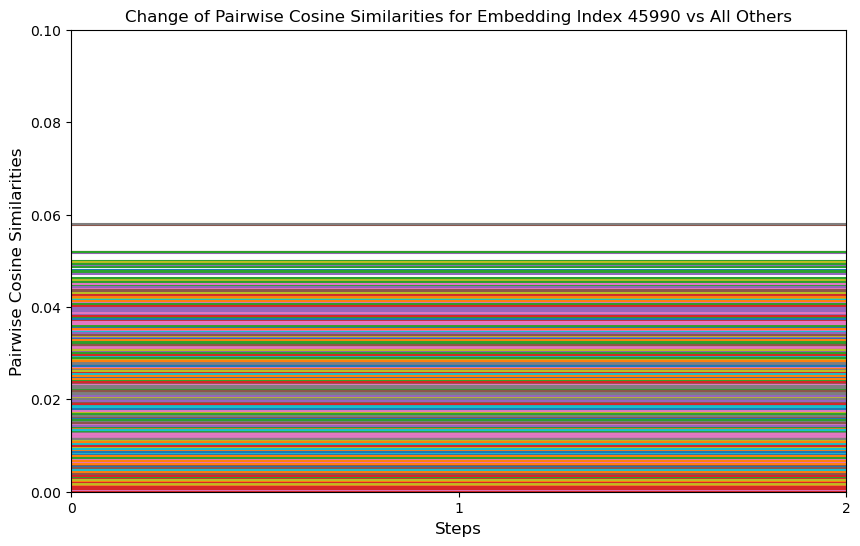

In [4]:
import pickle
import os
import re
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path

Path("./pairwise-sims-plots/").mkdir(parents=True, exist_ok=True)

n_samples = 3
dir = './pairwise-sims/'
y = [[] for i in range(n_samples)]
x = [[] for i in range(n_samples)]
subsample_idx = np.random.randint(0, 50688, n_samples)
print(f'sampling from embedding at indices {subsample_idx}')

# files are not necessarily listed in increasing step order, so do a little
# magic to sort them integer-aly
files = os.listdir(dir)
files.sort(key = lambda x: int(re.findall(r'\d+', x)[0]))

for filename in files:
    # this will be the x axis
    step_num = re.findall(r'\d+', filename)[0]    
    filepath = os.path.join(dir, filename)
    print(filepath)
    
    with open(filepath, 'rb') as infile:
        sim_matrix, norms = pickle.load(infile)
        
        for i in range(n_samples):
            # this would be the y axis (after concat and transpose)
            # [i] as index to maintain the dimensionality of index selected
            pairwise_sims = sim_matrix[subsample_idx[[i]]]
            
            x[i].append(int(step_num))
            y[i].append(pairwise_sims)

for i in range(n_samples):
    fig, ax = plt.subplots(figsize=(10, 6))
    # after this op, y should have shape (n_samples, 50688)
    y_temp = np.concatenate(y[i], axis=0)
    # remove the self cosine-similarity which will be 1 (or 1.000001 just because) 
    y_temp = np.delete(y_temp, subsample_idx, 1)

    # set colors for the lines so it isn't a giant blue homogenous rectangle.
    # https://matplotlib.org/gallery/color/color_cycle_default.html
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # use line collection and overly complex code to attach x coords to the list of y values
    x_temp = np.broadcast_to(x[i], y_temp.T.shape)
    segments = LineCollection(np.array(list(zip(x_temp, y_temp.T))).swapaxes(1,2), colors=colors)
    ax.add_collection(segments)

    plt.xticks(ticks=x[i])
    # change this lim as necessary
    ax.set_ylim(0,0.1)
    # Label the axes
    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Pairwise Cosine Similarities', fontsize=12)
    ax.set_title(f'Change of Pairwise Cosine Similarities for Embedding Index {subsample_idx[i]} vs All Others')
    plt.savefig(f'./pairwise-sims-plots/cos_sim_{subsample_idx[i]}.png')
    plt.show()